### Mallorca (balearic grid)
1. Begins: 2019-09-29 00:00:00
2. Ends: 2019-12-31 23:59:59

### Iceland
1. Begins: 2021-11-05 08:28:40
2. Ends: 2022-01-30 23:59:59

### Ireland
1. Begins: 2021-11-04 16:10:01
2. Ends: 2022-02-22 23:59:59


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import diptest
from numpy import random

from scipy.stats import skew, kurtosis
from scipy.optimize import curve_fit

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression

from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import acf

import plotly.express as px
import plotly.io as pio

from MFDFA import MFDFA
from MFDFA import fgn

#### Load dataset

In [2]:
# Set the directory path and filenames
folder_path = 'C:/1. Power grid frequency data/'
file_names = ['ES_PM01.csv', 'IS02.csv', 'IRL01.csv']

# Load the CSV files into dataframes
dataframes = []
for file_name in file_names:
    file_path = os.path.join(folder_path, file_name)
    df = pd.read_csv(file_path, sep=';', 
                     usecols=[0,1,2], names=['Time','f50','QI'],
                     header=0)
    df.iloc[:,1]=df.iloc[:,1]/1000+50
    dataframes.append(df)


# Only select quality QI=0
flt_dataframes = []
for df in dataframes:
    flt_dfs = df[df['QI'] == 0].dropna()
    flt_dataframes.append(flt_dfs)
    
region_dict = {0: 'Balearic', 1: 'Iceland', 2: 'Ireland'}

# Group the dataframes by region
region_groups = [df.groupby(lambda x: region_dict[i]) for i, df in enumerate(flt_dataframes)]
colors=('#66a61e', '#e6ab02','#a6761d')

#### Time series plot for flt_dataframes

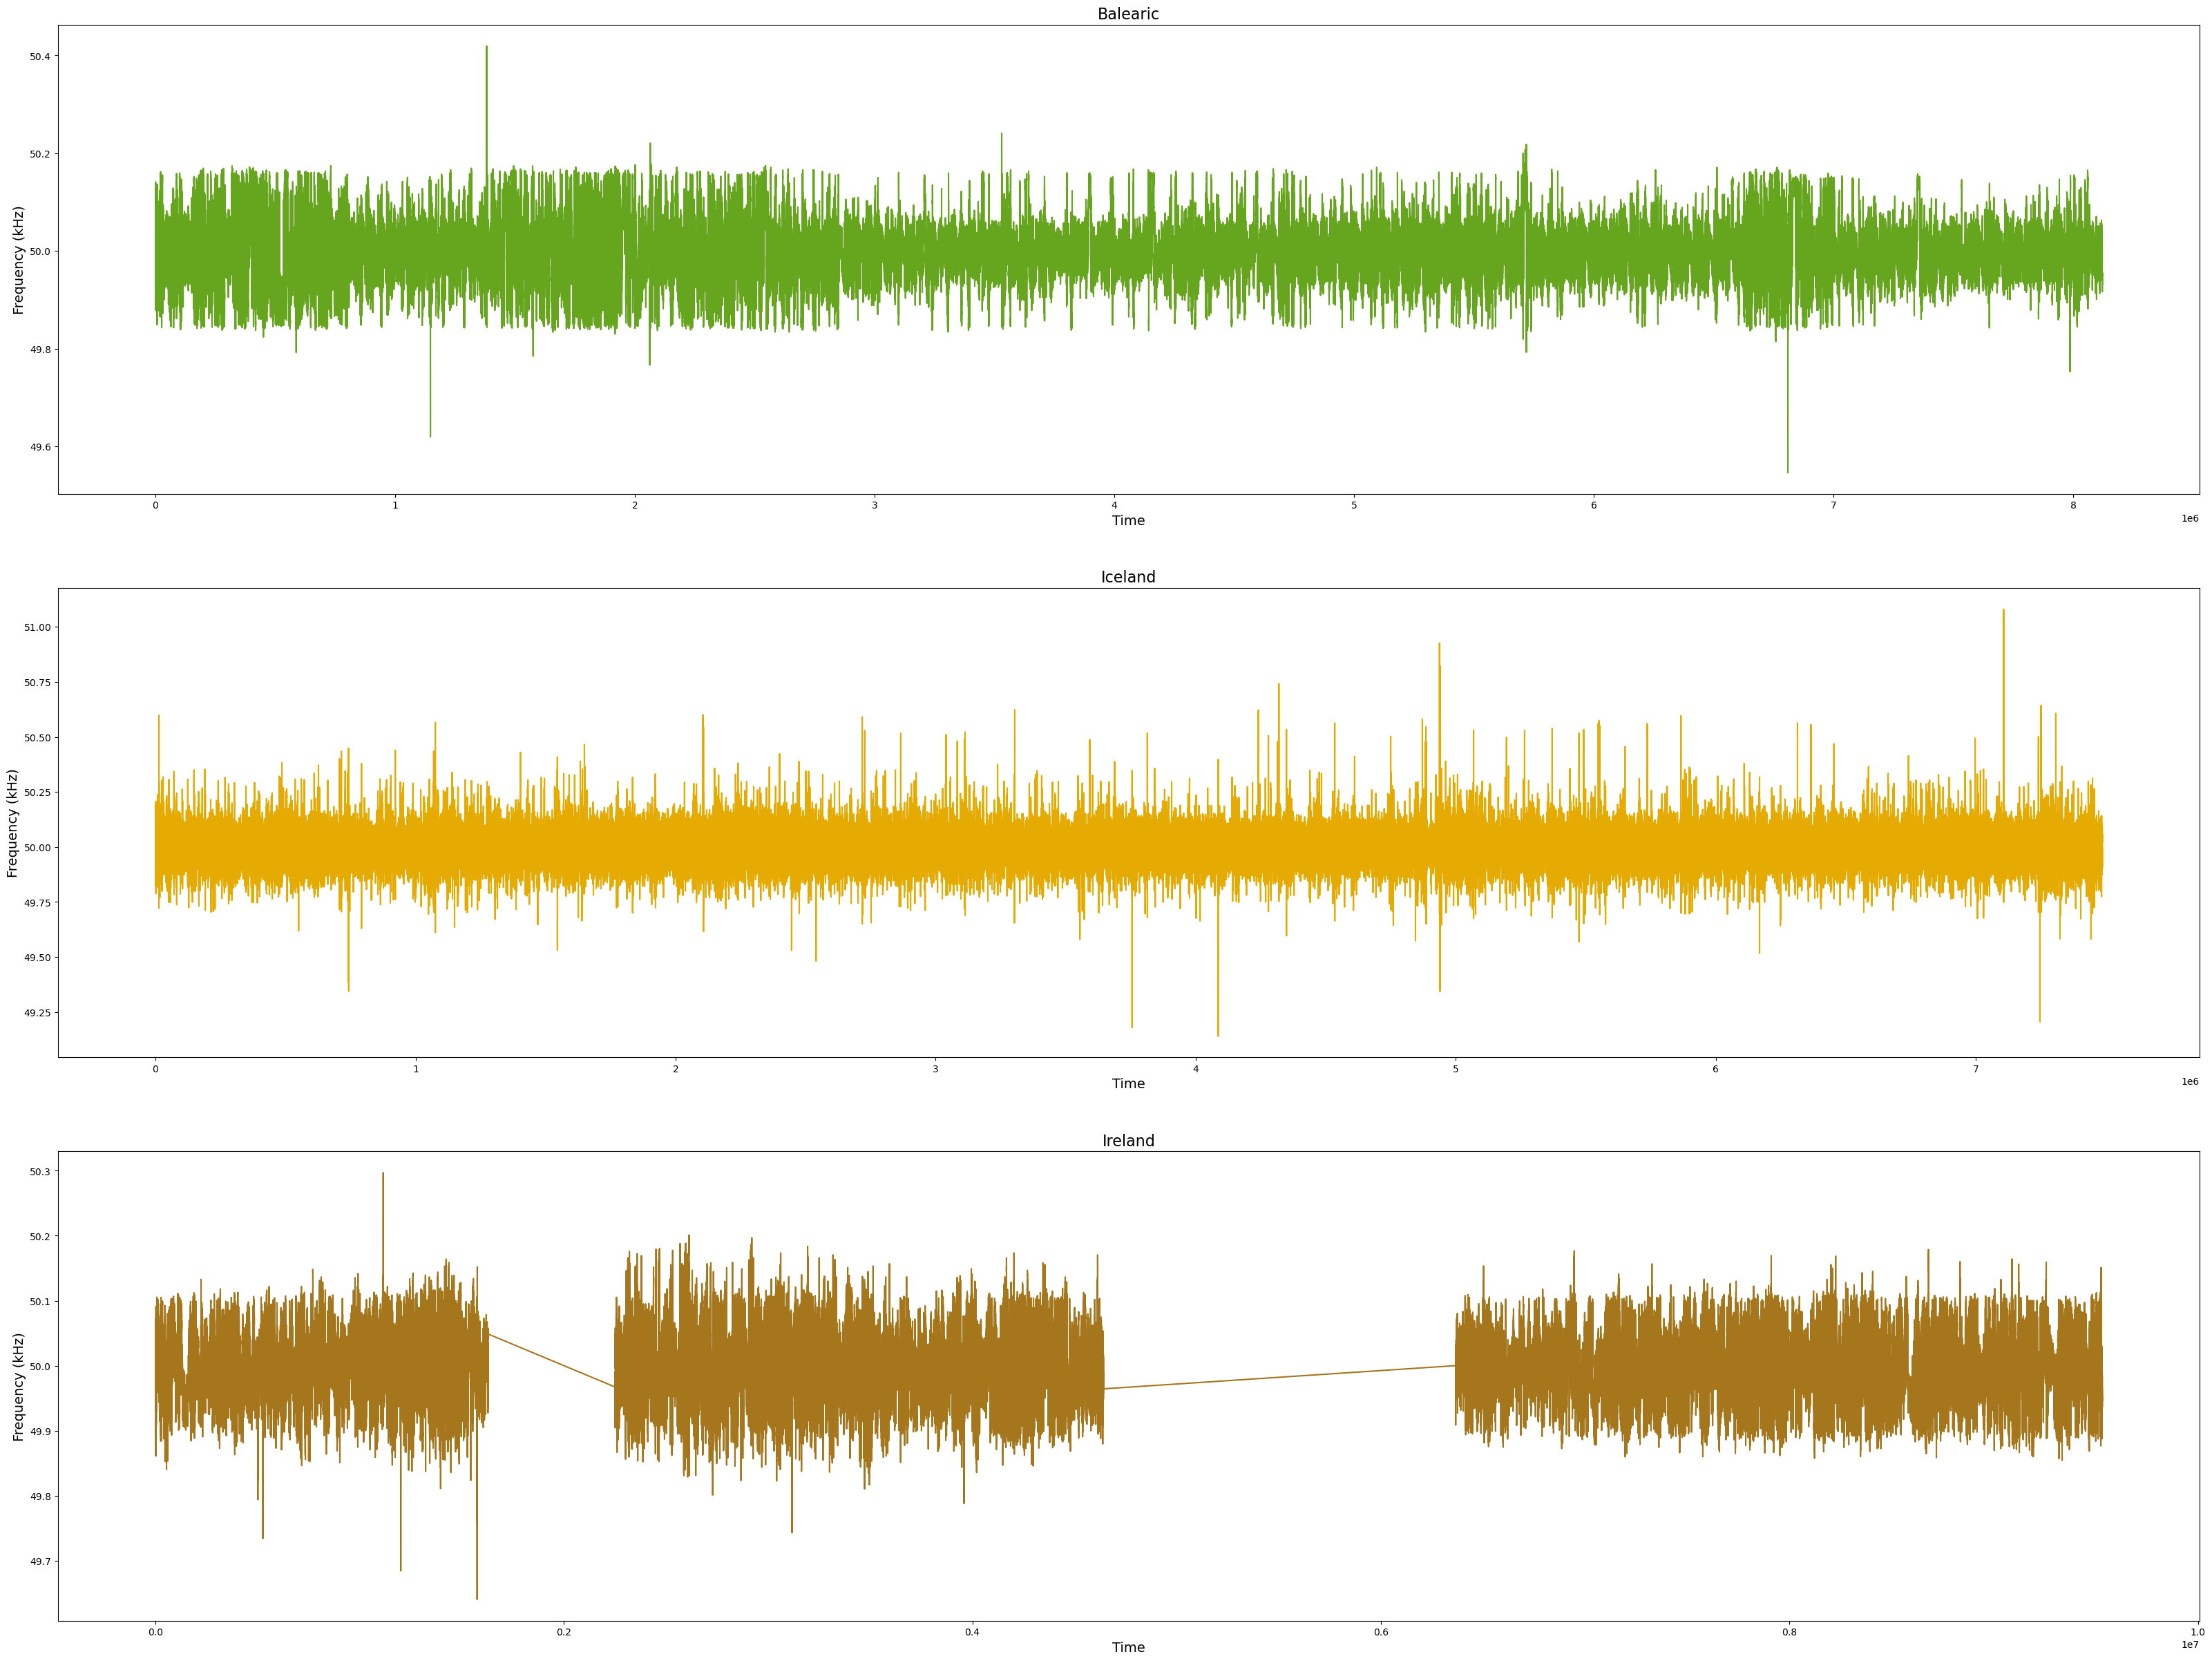

In [3]:
fig, axs = plt.subplots(nrows=len(flt_dataframes), figsize=(40,30))

for i, df in enumerate(flt_dataframes):
    axs[i].plot(df['f50'],color=colors[i])
    axs[i].set_title(region_dict[i], fontsize=16)
    axs[i].set_xlabel('Time', fontsize=14)
    axs[i].set_ylabel('Frequency (kHz)',fontsize=14)

#plt.tight_layout()
plt.rcParams.update({'font.family': 'Times New Roman'})
plt.show()

#### Remove gaps

In [4]:
# Find the longest continuous part for each region
filter_data = []
for df in flt_dataframes:
    # Convert the 'Time' column to datetime type
    df['Time'] = pd.to_datetime(df['Time'])
    time_diff = df['Time'].diff()

    # Find the longest continuous part by grouping consecutive timestamps with the same difference
    groups = (time_diff != pd.Timedelta(seconds=1)).cumsum()
    max_group = groups.value_counts().idxmax()

    # Filter the DataFrame to retain only the longest continuous part
    longest_continuous_df = df[groups == max_group]
    filter_data.append(longest_continuous_df)
    
filter_dict = {0: 'Balearic', 1: 'Iceland', 2: 'Ireland'}

#### Time series plot for filter_data

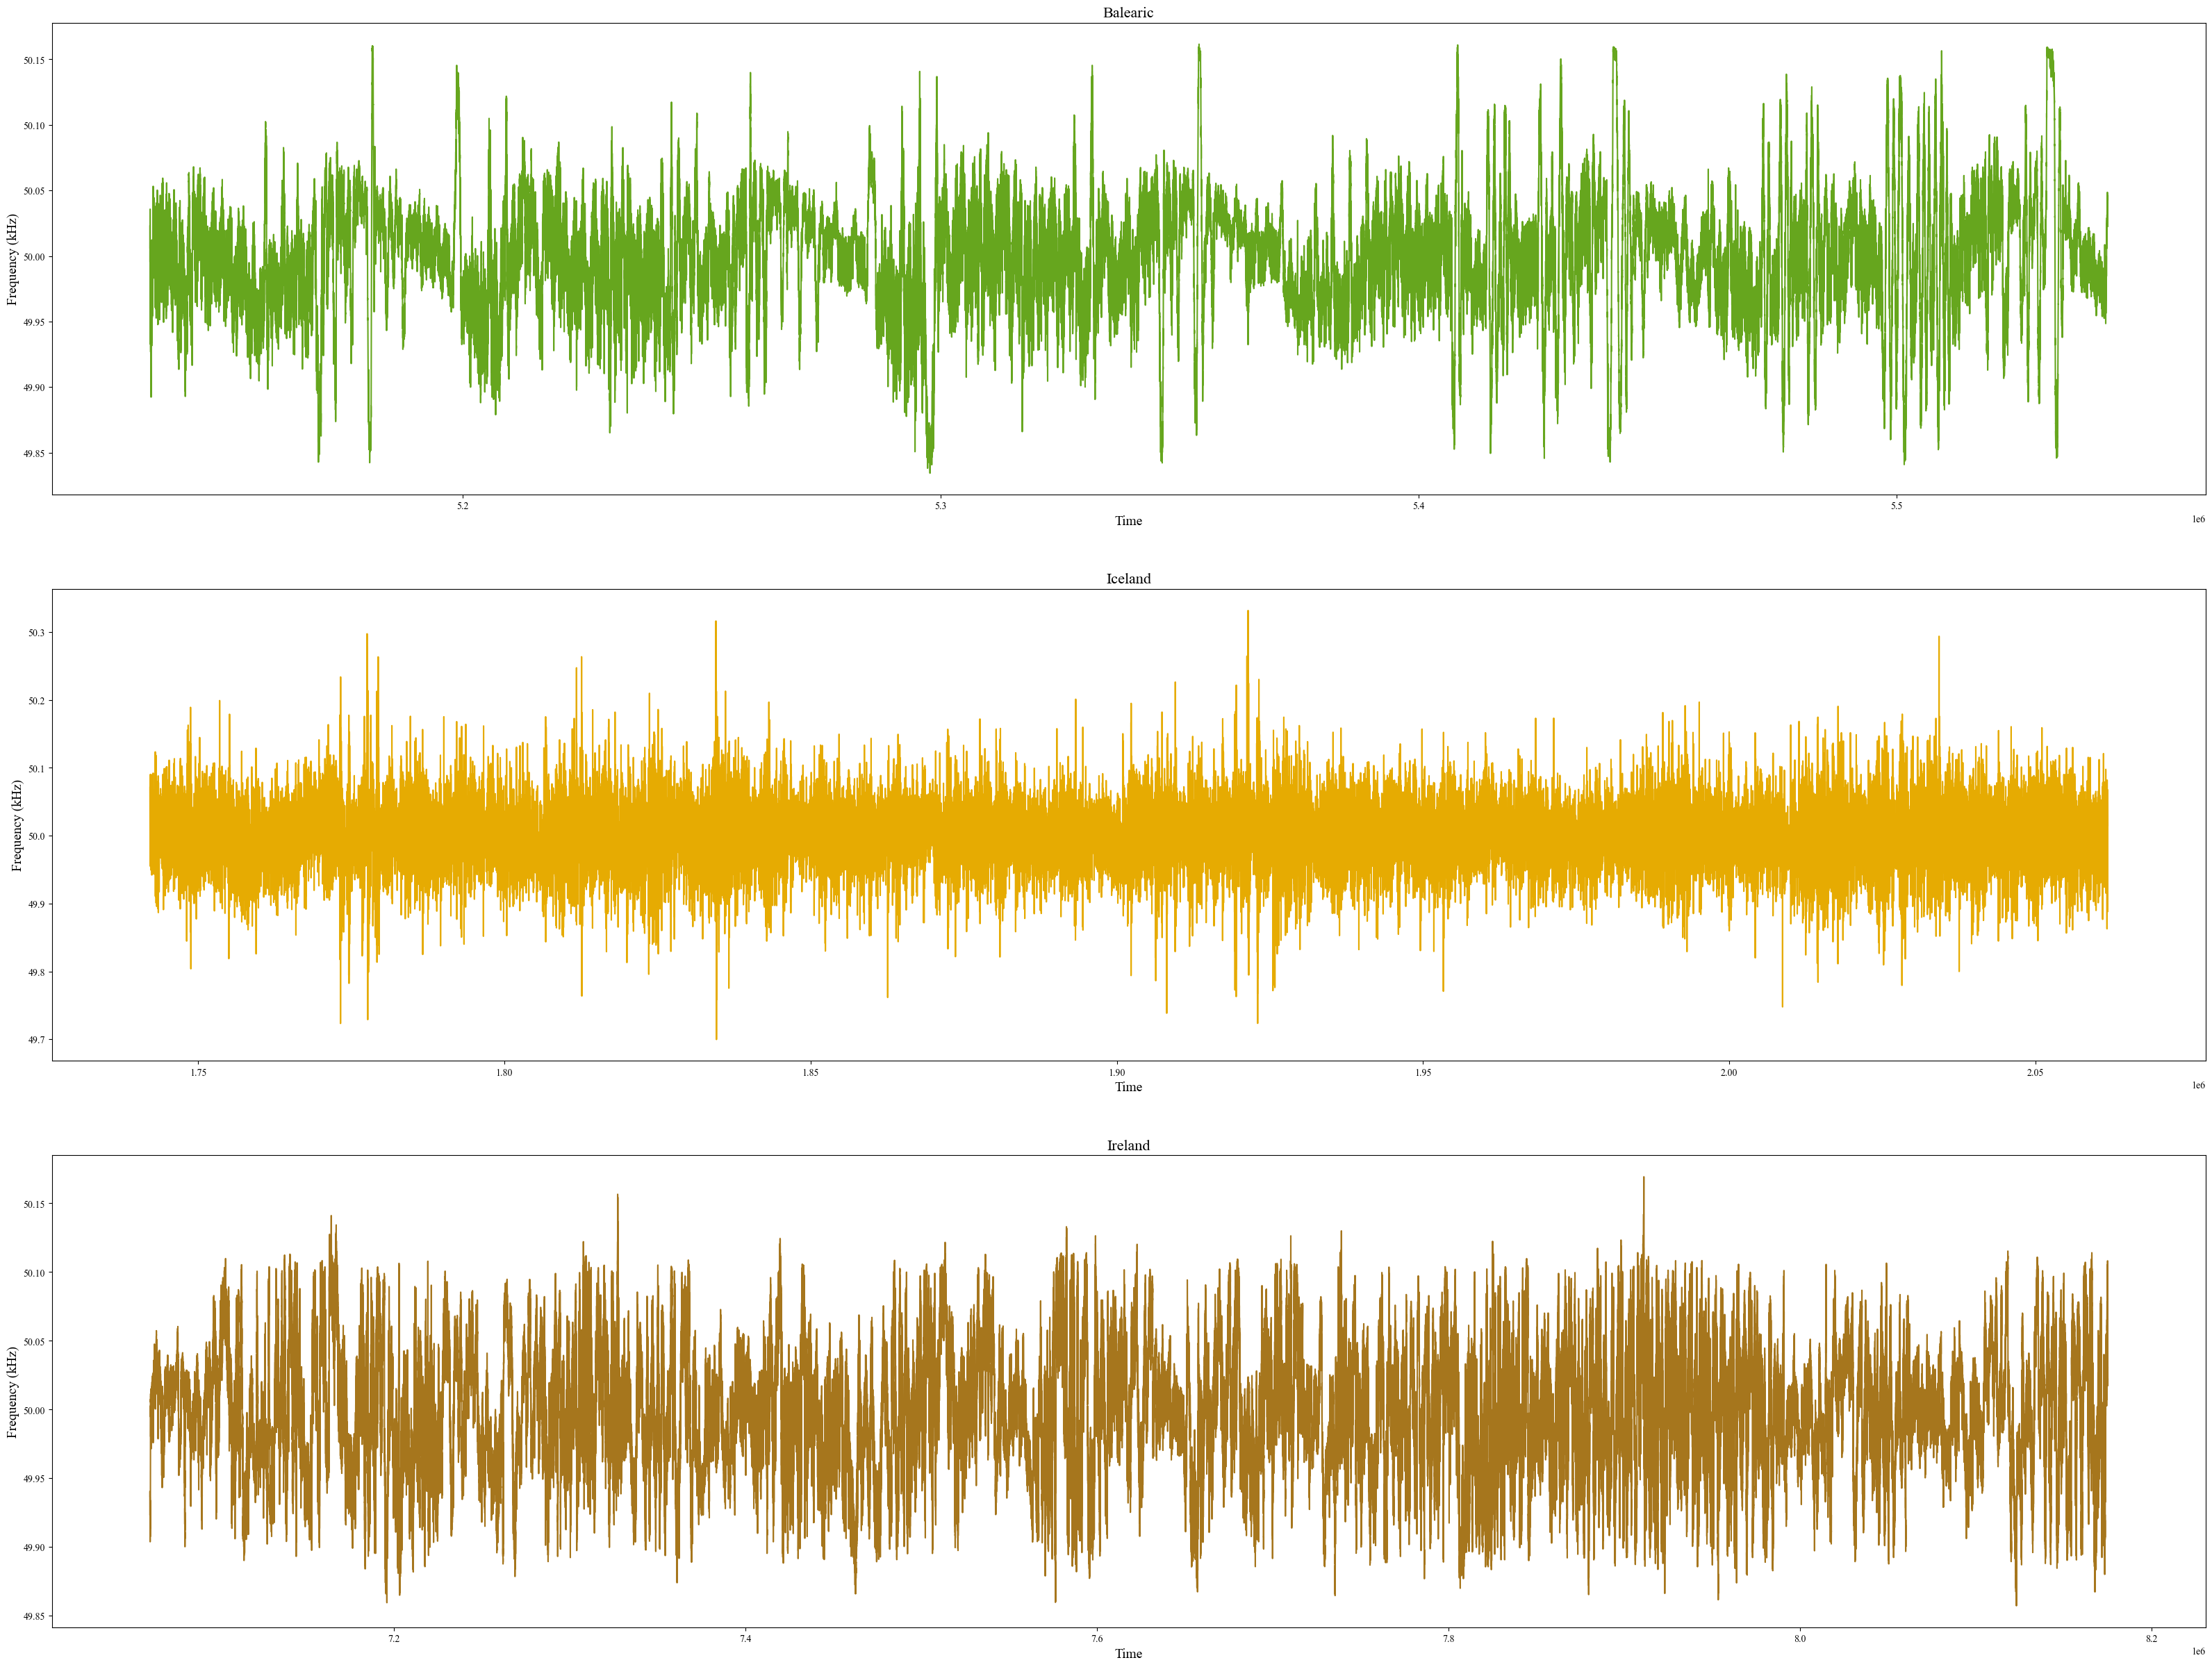

In [18]:
fig, axs = plt.subplots(nrows=len(filter_data), figsize=(40,30))

for i, df in enumerate(filter_data):
    axs[i].plot(df['f50'],color=colors[i])
    axs[i].set_title(region_dict[i], fontsize=16)
    axs[i].set_xlabel('Time', fontsize=14)
    axs[i].set_ylabel('Frequency (kHz)',fontsize=14)

#plt.tight_layout()
plt.rcParams.update({'font.family': 'Times New Roman'})
plt.show()

#### Stationary test for filter_data

In [74]:
for i, df in enumerate(filter_data):
    data = df.iloc[:, 1].dropna().values
    result = kpss(data, regression="c", nlags=0)
    test_statistic = result[0]
    p_value = result[1]

    # Assuming a 5% significance level
    critical_value_5percent = result[3]['5%']

    if test_statistic > critical_value_5percent:
        print(f"Region {filter_dict[i]}: Test Statistic = {test_statistic:.4f}, p-value = {p_value:.4f} (Non-Stationary)")
    else:
        print(f"Region {filter_dict[i]}: Test Statistic = {test_statistic:.4f}, p-value = {p_value:.4f} (Stationary)")



Region Balearic: Test Statistic = 124.6168, p-value = 0.0100 (Non-Stationary)
Region Iceland: Test Statistic = 5.5887, p-value = 0.0100 (Non-Stationary)
Region Ireland: Test Statistic = 52.2583, p-value = 0.0100 (Non-Stationary)


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.




#### Frequency distribution plot

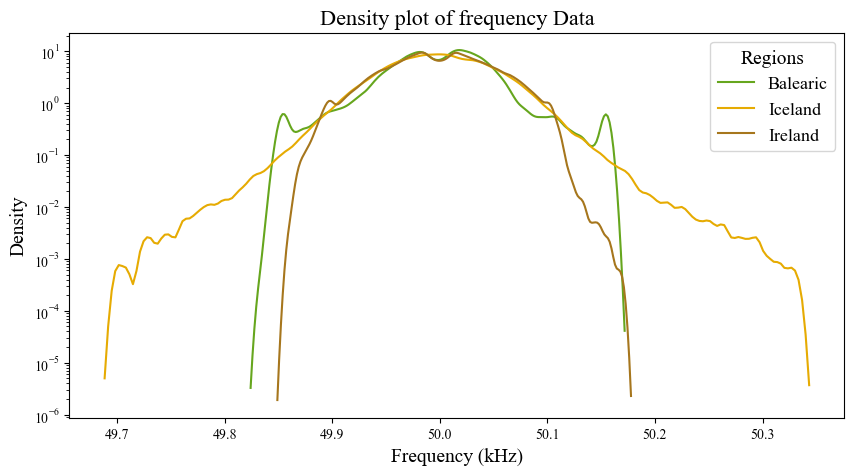

In [67]:
fig, ax = plt.subplots(figsize=(10,5))

for i, df in enumerate(filter_data):
    data = df.iloc[:,1]
    sns.kdeplot(data, color=colors[i], ax=ax, label=region_dict[i])

ax.set_title('Density plot of frequency Data',fontsize=16)
ax.set_xlabel('Frequency (kHz)',fontsize=14)
ax.set_ylabel('Density',fontsize=14)
ax.set_yscale('log') 
#ax.set_xscale('log')

plt.legend(title = "Regions", title_fontsize=14, fontsize=13, loc='upper right')
plt.show()

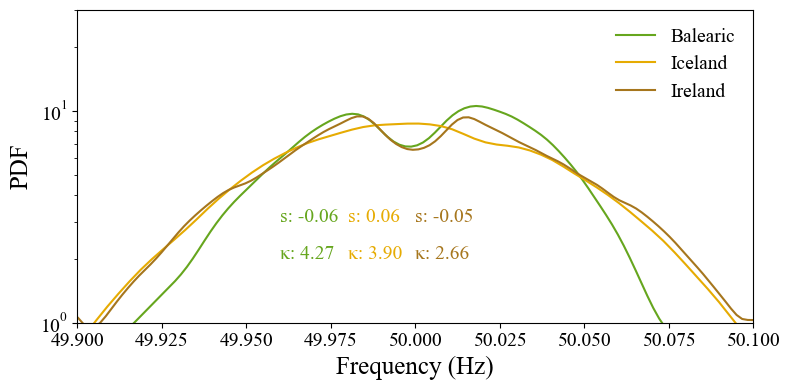

In [23]:
fig, ax = plt.subplots(figsize=(8, 4))

for i, df in enumerate(filter_data):
    data = df['f50']
    # Use Seaborn's kdeplot for plotting Kernel Density Estimation
    sns.kdeplot(data, color=colors[i], ax=ax, label=region_dict[i])

# Compute skewness and kurtosis for each dataset's 'f50'
# Appending results to respective lists
skewness = []
kurtosis = []

for df in filter_data:
    skewness.append(df['f50'].skew())
    kurtosis.append(df['f50'].kurtosis() + 3)  

#ax.set_title('Asia-Australia', fontsize=12)
ax.set_xlabel('Frequency (Hz)', fontsize=18)
ax.set_ylabel('PDF', fontsize=18)
ax.set_yscale('log') 
ax.set_xlim([49.9, 50.1])
ax.set_ylim([1, 30])
ax.tick_params(axis='y', labelsize=14)
ax.tick_params(axis='x', labelsize=14)

# Convert skewness and kurtosis lists to numpy arrays for vectorized operations
s = np.array(skewness)
k = np.array(kurtosis)

# Annotate the plot with skewness and kurtosis values, adjusting position for clarity
for i, (skew_val, kurt_val) in enumerate(zip(s, k)):
    ax.text(49.96+i*0.02, 3, f's: {skew_val.item():.2f}', color=colors[i], fontsize=14)
    ax.text(49.96+i*0.02, 2, f'\u03ba: {kurt_val.item():.2f}', color=colors[i], fontsize=14)

plt.legend(fontsize=14, loc='upper right', frameon=False)
plt.tight_layout()
plt.show()

#### Dip statistics

In [75]:
euro_dip=[]
for i, df in enumerate (filter_data):
    # Perform Dip Test on the 'f50' column after ensuring it's of float type
    dip,pval = diptest.diptest(df['f50'].astype(float))
    region=region_dict[i]
    euro_dip.append((dip))
%store euro_dip

Stored 'euro_dip' (list)


#### Increment frequency

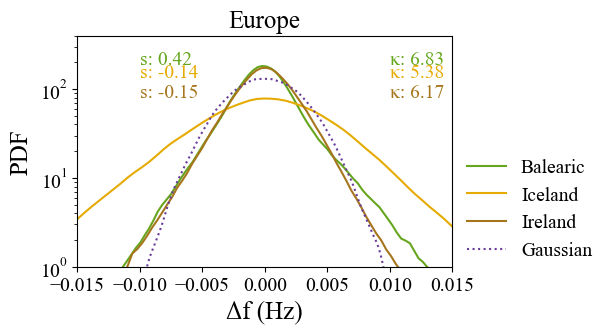

In [92]:
tau=1

fig, ax = plt.subplots(figsize=(6,3))

increment_dfs = []
for i, df in enumerate(filter_data):
    df_copy = df.copy()
    df_copy['increment_freq'] = df_copy.iloc[:,1].diff(periods=tau)
    increment_data = df_copy.dropna()
    increment_dfs.append(increment_data)
    
skewness = []
kurtosis = []

for df in increment_dfs:
    skewness.append(df['increment_freq'].skew())
    kurtosis.append(df['increment_freq'].kurtosis()+3)

# Plot the filtered data inside the loop
for i, df in enumerate(increment_dfs):
    sns.kdeplot(df['increment_freq'], color=colors[i], ax=ax, label=region_dict[i])
    
# Plot normal distribution curve
sns.kdeplot(random.normal(loc=0, scale=0.003,size=100000), color= '#6a3d9a', ax=ax, label='Gaussian',linestyle=":")

ax.set_title('Europe',fontsize=18)
ax.set_xlabel('\u0394f (Hz)',fontsize=18)
ax.set_ylabel('PDF',fontsize=18)
ax.set_yscale('log') 

ax.set_xlim([-0.015,0.015])
ax.set_ylim([1,400])

ax.tick_params(axis='y', labelsize=14)
ax.tick_params(axis='x', labelsize=14)

# Add skewness and kurtosis annotations
s = skewness  
k = kurtosis 

for i, (skew_val, kurt_val) in enumerate(zip(s, k)):
    ax.text(-0.01, 190-i*55, f's: {skew_val.item():.2f}', color=colors[i], fontsize=14)
    ax.text( 0.01, 190-i*55, f'\u03ba: {kurt_val.item():.2f}', color=colors[i], fontsize=14)


#plt.legend(fontsize=11, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.legend(fontsize=14,bbox_to_anchor = (1.42, 0.25), loc='center right',frameon=False)

# Adjust subplot spacing
plt.subplots_adjust(right=0.75)


plt.rcParams.update({'font.family': 'Times New Roman'})
plt.savefig('C:/4. Paper plots/fig 4b.pdf')
#plt.show()


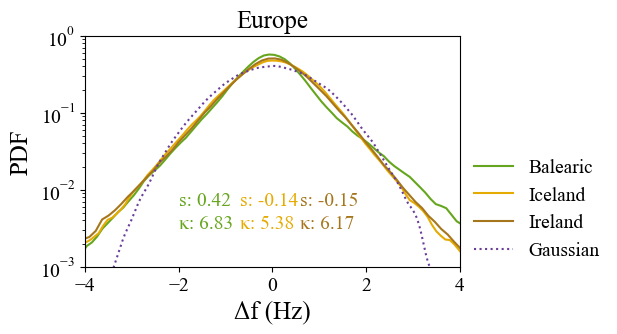

In [9]:
tau = 1

fig, ax = plt.subplots(figsize=(6, 3))

increment_dfs = []

for i, df in enumerate(filter_data):
    df_copy = df.copy()
    df_copy['increment_freq'] = df_copy.iloc[:, 1].diff(periods=tau)
    increment_data = df_copy.dropna().copy()  # Create a copy to avoid SettingWithCopyWarning
    
    # Normalize the increment frequency column to have mean 0 and standard deviation 1
    mean = increment_data['increment_freq'].mean()
    std = increment_data['increment_freq'].std()
    increment_data['normalized_increment_freq'] = (increment_data['increment_freq'] - mean) / std
    
    increment_dfs.append(increment_data)

skewness = []
kurtosis = []

for df in increment_dfs:
    skewness.append(df['normalized_increment_freq'].skew())
    kurtosis.append(df['normalized_increment_freq'].kurtosis() + 3)

# Plot the filtered data inside the loop
for i, df in enumerate(increment_dfs):
    sns.kdeplot(df['normalized_increment_freq'], color=colors[i], ax=ax, label=region_dict[i])

# Plot normal distribution curve
sns.kdeplot(random.normal(loc=0, scale=1, size=100000), color='#6a3d9a', ax=ax, label='Gaussian', linestyle=":")

ax.set_title('Europe', fontsize=18)
ax.set_xlabel('Δf (Hz)', fontsize=18)
ax.set_ylabel('PDF', fontsize=18)
ax.set_yscale('log')

ax.set_xlim([-4,4])
ax.set_ylim([1e-3, 1])

ax.tick_params(axis='y', labelsize=14)
ax.tick_params(axis='x', labelsize=14)

# Add skewness and kurtosis annotations
s = skewness  
k = kurtosis 

for i, (skew_val, kurt_val) in enumerate(zip(s, k)):
    ax.text(-2+i*1.3, 10**-2.2, f's: {skew_val.item():.2f}', color=colors[i], fontsize=14)
    ax.text(-2+i*1.3, 10**-2.5, f'\u03ba: {kurt_val.item():.2f}', color=colors[i], fontsize=14)

plt.legend(fontsize=14, bbox_to_anchor=(1.42, 0.25), loc='center right', frameon=False)

# Adjust subplot spacing
plt.subplots_adjust(right=0.75)

plt.rcParams.update({'font.family': 'Times New Roman'})
plt.savefig('C:/4. Paper plots/fig 4b.pdf')
#plt.show()

#### Autocorrelation plot

Stored 'euro_lambda' (list)


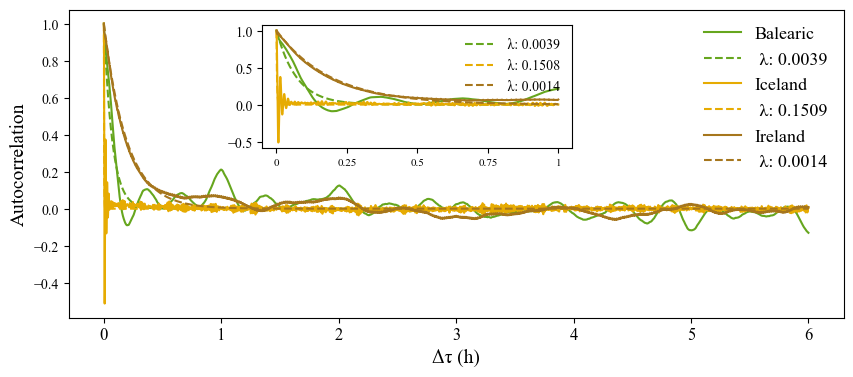

In [10]:
# Define the exponential decay function
def exp_decay(t, lamb):
    return np.exp(-lamb * t)

euro_lambda = []
euro_lambda_inset = []

fig, ax = plt.subplots(figsize=(10, 4))

# Create an inset inside the main ax
axins = ax.inset_axes([0.25, 0.55, 0.40, 0.40]) # [x, y, width, height] of the inset

# Assuming filter_data is a list of dataframes where each dataframe contains data for a region
for i, df in enumerate(filter_data):
    data = df.iloc[:, 1]
    acf_vals = acf(data, nlags=3600*6)
    acf_vals_inset = acf(data, nlags=3600) # This is for the inset
    
    t_values = np.arange(len(acf_vals))
    t_values_inset = np.arange(len(acf_vals_inset))
    
    # Use curve_fit to fit the acf values to the exp_decay function
    popt, _ = curve_fit(exp_decay, t_values, acf_vals, p0=(0.001))
    popt_inset, _ = curve_fit(exp_decay, t_values_inset, acf_vals_inset, p0=(0.001))
    
    lambdas = popt[0]
    euro_lambda.append(lambdas)
    lambda_inset = popt_inset[0] # For the inset
    euro_lambda_inset.append(lambda_inset)
    
    ax.plot(acf_vals, color=colors[i], label=f"{region_dict[i]}")
    ax.plot(exp_decay(t_values, *popt), linestyle='--', 
            color=colors[i], label=f" λ: {lambdas:.4f}")
    
    # Plot on the inset
    axins.plot(acf_vals_inset, color=colors[i])
    axins.plot(exp_decay(t_values_inset, *popt_inset), linestyle='--', 
               color=colors[i], label=f" λ: {lambda_inset:.4f}")

# Set properties of the main plot
ax.set_xlabel('Δτ (h)', fontsize=14)
ax.set_ylabel('Autocorrelation', fontsize=14)
ticks = np.arange(0, 3600*7, 3600)
tick_labels = [f'{i//3600}' for i in ticks]
ax.set_xticks(ticks)
ax.set_xticklabels(tick_labels, fontsize=12)
ax.legend(fontsize=13, loc='upper right', frameon=False)

# Set properties of the inset
#axins.set_title('First 3600 lags')
axins.set_xticks(np.arange(0, 3601, 900)) # Every 15 minutes which is 0.25 hours
axins.set_xticklabels(['0', '0.25', '0.5', '0.75', '1'], fontsize=8)
axins.legend(fontsize=10, loc='upper right', frameon=False)

plt.savefig('C:/4. Paper plots/fig 6b.pdf')
#plt.show()
%store euro_lambda

#### Linear test

In [111]:
def linear_test (data):
    # Compute Fourier transform 
    fft_0 = np.fft.fft(data)
    
    # Randomize phases of Fourier coefficients
    rand_phases = np.random.uniform(0, 2*np.pi, size=len(fft_0))
    surrogate = np.abs(fft_0) * np.exp(1j * rand_phases)
    
    # Compute inverse Fourier transform to obtain surrogate data
    surrogate = np.real(np.fft.ifft(surrogate))
    
    # Remove NaN values from the data, get the length of the data
    data = data[~np.isnan(data)]
    L = len(data)
    
    # Define the time lags (tau)
    tau = np.arange(1, 82801,540 )
    #tau = np.arange(0, L//2, 3600)
    
    # Initialize arrays to store results
    surr_2 = np.zeros(len(tau))
    
    # Calculate moments for different time lags
    for i in range(len(tau)):
        x_t = data[0 :L-tau[i]]
        x_tau = data[tau[i]:L]
        y_t = surrogate[0:(L-tau[i])]
        y_tau = surrogate[(tau[i]):L]

        res_2[i] = np.mean((x_t-x_tau)**3)/np.mean((x_t-x_tau)**2)
        surr_2[i] = np.mean((y_t-y_tau)**3)/np.mean((y_t-y_tau)**2)
            
    # Calculate the RMSE between the original and surrogate data
    mse_lt2 = mean_squared_error(np.nan_to_num(res_2), np.nan_to_num(surr_2))
    rmse_lt2 = np.sqrt(mse_lt2)
    
    # Return the calculated RMSE
    return rmse_lt2

In [112]:
# Calculate LTtest for each dataset in dataframes
euro_lt = []
for i, df in enumerate(filter_data):
    # Get the frequency values and drop NaN values
    data = df.f50.dropna().values
    
    # Calculate RMSE using linear_test function
    rmse_lt2 = linear_test(data)
    
    # Append a tuple containing region name and RMSE to euro_lt list
    euro_lt.append((filter_dict[i], rmse_lt2))
%store euro_lt

Stored 'euro_lt' (list)


In [113]:
euro_lt

[('Balearic', 0.008796455567334317),
 ('Iceland', 0.002202797073890858),
 ('Ireland', 0.0033796971961773405)]

#### Chapman-Kolmogorov test

In [96]:
def chapman_Kolmogorov_test (data, tau1, tau2, tau3, bins):
    # Extracting data slices for different time lags
    data1 = data[tau1:-tau1] # x3
    data2 = data[tau2:-tau2] # x2
    data3 = data[tau3:-tau3] # x1
    
    # Find bin borders
    dx1 = np.ptp(data3/(bins-1))  # the difference between max and min of data
    dx2 = np.ptp(data2)/(bins-1)
    dx3 = np.ptp(data1)/(bins-1)
    x1 = np.arange(min(data3), np.max(data3)+dx1, dx1)
    x2 = np.arange(min(data2), np.max(data2)+dx2, dx2)
    x3 = np.arange(min(data1), np.max(data1)+dx3, dx3)
    dA = dx1 * dx2
    dV = dx1 * dx2 * dx3
    
    # Finding 2D conditional PDF P(Xt|X(t-1)) or P(x1|x2)
    X = np.column_stack((data3[:len(data3)], data2[:len(data3)]))
    count, edges = np.histogramdd(X, bins=[x1, x2])
    p_12_ref = count/(len(X)*dA)  # Joint PDF of x1, x2
    
    # Calculate 1D PDF p_2
    p_2 = np.zeros(bins-1) # 1d PDF P(x2)
    
    for j in range(bins-1):
        p_2[j] = np.sum(p_12_ref[j,:]) * dx1
        
        # Initialize p_1_2
        p_1_2 = np.zeros((bins-1, bins-1))
        
    # Calculate conditional PDF p_1_2
    for j in range(bins-1):
        if p_2[j] > 0:
            p_1_2[:,j] = p_12_ref[:,j] / p_2[j]

            
    # Set values less than 1e-3 to zero
    p_1_2[p_1_2 < 1e-3] = 0
    
    #Finding 3D conditional PDF P(X_t|X_(t-1),X_(t-2)) or P(x1|x2,x3)
    Y = np.zeros((len(data3), 3))
    Y[:, 0] = data3[:len(data3)]
    Y[:, 1] = data2[:len(data3)]
    Y[:, 2] = data1[:len(data3)]


    edges = (x1, x2, x3)
    count, edges = np.histogramdd(Y, bins=edges)
    mid = [0.5 * (edges[i][1:] + edges[i][:-1]) for i in range(3)]
    loc = np.array(np.unravel_index(np.arange(bins ** 3), (bins, bins, bins)), order='F').T

    # calculate the joint PDF of x2 and x3
    p_123_ref = count / (len(Y) * dV) # % Conditional PDF P(x1|x2,x3)
    p_23 = np.zeros((bins-1, bins-1))
    for i in range(bins-1):
        for j in range(bins-1):
            p_23[i, j] = np.sum(p_123_ref[i, j, :]) * dx1
            
    # calculate the conditional PDF of x1 given x2 and x3
    p_1_23 = np.zeros((bins-1, bins-1, bins-1))
    for i in range(bins-1):
        for j in range(bins-1):
            if p_23[i, j] > 0:
                p_1_23[:, i, j] = p_123_ref[:, i, j] / p_23[i, j]

    
    return x1, x2, p_1_2,p_1_23
    

In [97]:
# Define tau value sets
tau_sets = [
    [2, 4, 6],
    [5,10, 15],
    [20, 40, 60],
    [30, 60, 90],
    [50, 100, 150],
    [70, 140, 210],
    [90, 180, 270],
    [100, 200, 300],
    [200, 400, 600],
    [300, 600, 900],
    [400, 800, 1200],
    [500, 1000, 1500],
    [600, 1200, 1800],
    [700, 1400, 2100],
    [800, 1600, 2400],
    [900, 1800, 2700],
    [1000, 2000, 3000]
    
]

In [98]:
bal_distances=[]

# Iterate through tau value sets
for tau in tau_sets: 
    # Calculate CK test for dataframe
    x1, x2, p_1_2, p_1_23 = chapman_Kolmogorov_test(filter_data[0].f50.dropna().values, tau[0], tau[1], tau[2], 50)
    
    # Normalize p_1_2 and p_1_23
    p_1_2_normalized = p_1_2 / np.sum(p_1_2)
    p_1_23_normalized = p_1_23 / np.sum(p_1_23)
    
    # Calculate distance 
    distance = -np.log(np.sum(np.sqrt(p_1_2_normalized* p_1_23_normalized[:, :, 25])))
    bal_distances.append(distance)

In [99]:
ice_distances=[]

# Iterate through tau value sets
for tau in tau_sets: 
    # Calculate CK test for dataframe
    x1, x2, p_1_2, p_1_23 = chapman_Kolmogorov_test(filter_data[1].f50.dropna().values, tau[0], tau[1], tau[2], 52)
    
    # Normalize p_1_2 and p_1_23
    p_1_2_normalized = p_1_2 / np.sum(p_1_2)
    p_1_23_normalized = p_1_23 / np.sum(p_1_23)
    
    # Calculate distance 
    distance = -np.log(np.sum(np.sqrt(p_1_2_normalized* p_1_23_normalized[:, :, 25])))
    ice_distances.append(distance)

In [100]:
ire_distances=[]

# Iterate through tau value sets
for tau in tau_sets: 
    # Calculate CK test for dataframe
    x1, x2, p_1_2, p_1_23 = chapman_Kolmogorov_test(filter_data[2].f50.dropna().values, tau[0], tau[1], tau[2], 51)
    
    # Normalize p_1_2 and p_1_23
    p_1_2_normalized = p_1_2 / np.sum(p_1_2)
    p_1_23_normalized = p_1_23 / np.sum(p_1_23)
    
    # Calculate distance 
    distance = -np.log(np.sum(np.sqrt(p_1_2_normalized* p_1_23_normalized[:, :, 25])))
    ire_distances.append(distance)

Stored 'euro_dis' (list)


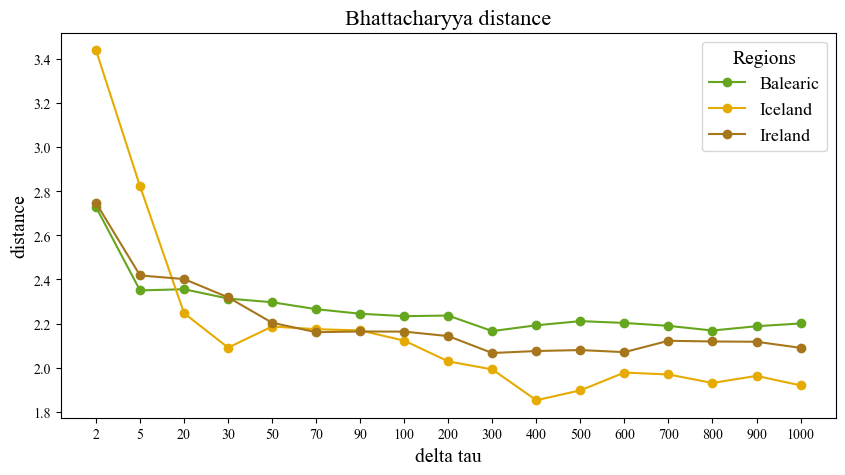

In [102]:
euro_dis=[bal_distances,ice_distances,ire_distances]
%store euro_dis


fig, ax = plt.subplots(figsize=(10,5))

for i, df in enumerate(euro_dis):
    ax.plot(range(len(tau_sets)),df, 'o-',color=colors[i], label=region_dict[i])
    ax.set_title('Bhattacharyya distance',fontsize=16)
    ax.set_xlabel('delta tau',fontsize=14)
    ax.set_ylabel('distance',fontsize=14)

#ax.set_xticklabels([0,2,5,20,30,50,70,90,100], fontsize=12)
plt.xticks(range(len(tau_sets)),[2,5,20,30,50,70,90,100,200,300,400,500,600,700,800,900,1000]) 
plt.legend(title = "Regions", title_fontsize=14, fontsize=13, loc='upper right')

plt.show()

#### DFA

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


Slope for Balearic: [1.69106829]
Slope for Iceland: [2.05405112]
Slope for Ireland: [1.6623262]


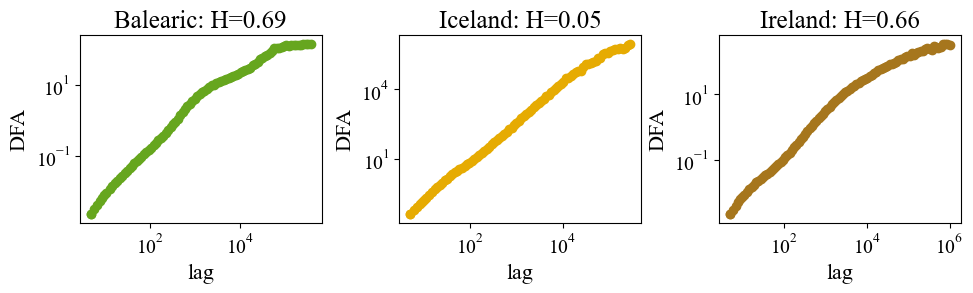

In [7]:
# Create a 1x3 grid of subplots
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(10, 3))

# Add spacing between subplots
fig.tight_layout(pad=3.0)  

# Define parameters for MFDFA analysis
lag = np.logspace(0.7, 6, 100).astype(int)
q = 2
order = 1

for i, df in enumerate(filter_data):
    if i == 1:  # For filter data 2
        lag, dfa = MFDFA(df['f50'].dropna().values, lag=lag, q=q, order=order, modified=True)
        polyfit = np.polyfit(np.log(lag[:10]), np.log(dfa[:10]), 1)
        Hurst = polyfit[0] - 2  # Calculate Hurst exponent for filter data 2, under moditied=True
    else:
        lag, dfa = MFDFA(df['f50'].dropna().values, lag=lag, q=q, order=order)
        polyfit = np.polyfit(np.log(lag[:10]), np.log(dfa[:10]), 1)
        Hurst = polyfit[0] - 1  # Calculate Hurst exponent for the rest of the filter data

    ax = axs[i]  # Determine the subplot position
    ax.loglog(lag, dfa, 'o', label='fOU: MFDFA q=2', color=colors[i]) # Plot the MFDFA results
    ax.set_title(f"{region_dict[i]}: H={float(Hurst):.2f}", fontsize=18)
    ax.set_xlabel('lag', fontsize=16)
    ax.set_ylabel('DFA', fontsize=16)
    ax.tick_params(axis='y', labelsize=14)
    ax.tick_params(axis='x', labelsize=14)

    print(f"Slope for {region_dict[i]}: {polyfit[0]}")

plt.rcParams.update({'font.family': 'Times New Roman'})
#plt.show()
plt.savefig('C:/4. Paper plots/figure 7b.pdf')